In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

print('hello')
# Read data
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')


hello


In [47]:
# Data Preparation

numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score','converted']
categorical = list(set(df.columns)-set(numerical))

df[numerical] = df[numerical].fillna(0)
df[categorical] = df[categorical].fillna('NA')

df[categorical] = df[categorical].astype('category')

df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [48]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

df_all_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_all_train, test_size=0.25, random_state=1)

df_all_train.reset_index(inplace=True)
df_full_train = df_all_train.copy()
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_test.reset_index(inplace=True)

y_all_train = df_all_train['converted'].values
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

numerical.remove('converted')

In [49]:
# Question 1: ROC AUC feature importance

# Which numerical variable (among the following 4) has the highest AUC?
# lead_score
# number_of_courses_viewed
# interaction_count
# annual_income

target_columns = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for c in target_columns:
    y_predicted = df_train[c].values
    print('%s: %.3f' % (c, round(roc_auc_score(y_train, y_predicted),2)))


# Answers: number_of_courses_viewed
#lead_score: 0.610
#number_of_courses_viewed: 0.760
#interaction_count: 0.740
#annual_income: 0.550


lead_score: 0.610
number_of_courses_viewed: 0.760
interaction_count: 0.740
annual_income: 0.550


In [50]:
# Question 2: Training the model

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:,1]
#converted_decision = (y_pred > 0.5)

print("score: %.3f" % (roc_auc_score(y_val, y_pred)))


# Try another one by fitting all_train
dv2 = DictVectorizer(sparse=False)
X_all_train = dv2.fit_transform(df_all_train.to_dict(orient='records'))
X_test = dv2.transform(df_test.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_all_train, y_all_train)
y_pred2 = model.predict_proba(X_test)[:,1]
#converted_decision = (y_pred > 0.5)

print("score: %.3f" % (roc_auc_score(y_test, y_pred2)))

score: 0.827
score: 0.794


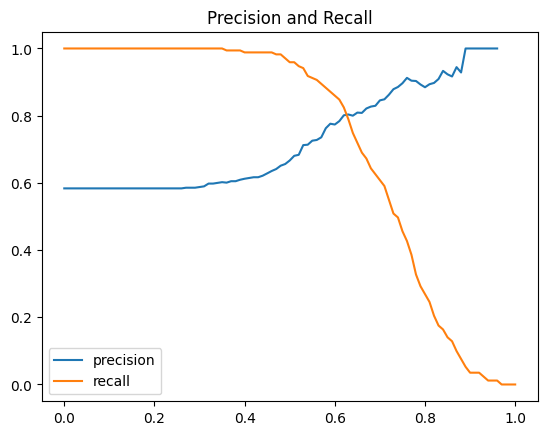

In [51]:
# Question 3: Precision and Recall

thresholds = np.arange(0,1.01,0.01)

actual_positive = (y_val==1)
actual_negative = (y_val==0)

precisions = []
recalls = []
tps = []
fps = []
fns = []
tns = []

for th in thresholds:
    predicted_positive = (y_pred >= th)
    predicted_negative = (y_pred < th)

    tps.append((actual_positive & predicted_positive).sum())
    fps.append((actual_negative & predicted_positive).sum())
    fns.append((actual_positive & predicted_negative).sum())
    tns.append((actual_negative & predicted_negative).sum())

    #precisions.append(tp / (tp + fp))
    #recalls.append(tp / (tp + fn))


pred_results = pd.DataFrame({'threshold': thresholds, 'tp': tps, 'fp': fps, 'fn': fns, 'tn': tns})
pred_results['precision'] = pred_results['tp']/(pred_results['tp']+pred_results['fp'])
pred_results['recall'] = pred_results['tp']/(pred_results['tp']+pred_results['fn'])

plt.plot(pred_results['threshold'], pred_results['precision'], label='precision')
plt.plot(pred_results['threshold'], pred_results['recall'], label='recall')
plt.legend()
plt.title('Precision and Recall')
plt.show()

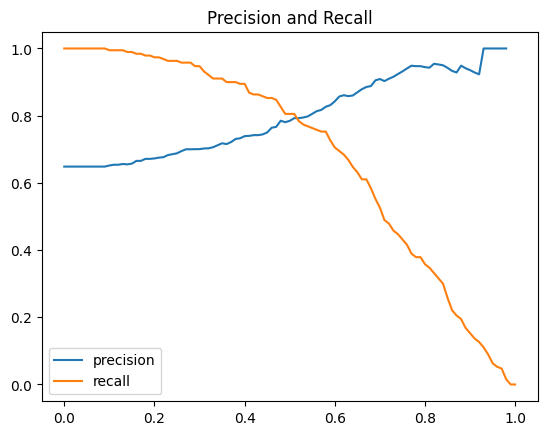

intersection at: 0.52


In [52]:
# Question 3 - use all_train and test instead:

actual_positive = (y_test==1)
actual_negative = (y_test==0)

precisions = []
recalls = []
tps = []
fps = []
fns = []
tns = []

for th in thresholds:
    predicted_positive = (y_pred2 >= th)
    predicted_negative = (y_pred2 < th)

    tps.append((actual_positive & predicted_positive).sum())
    fps.append((actual_negative & predicted_positive).sum())
    fns.append((actual_positive & predicted_negative).sum())
    tns.append((actual_negative & predicted_negative).sum())

    #precisions.append(tp / (tp + fp))
    #recalls.append(tp / (tp + fn))


pred2_results = pd.DataFrame({'threshold': thresholds, 'tp': tps, 'fp': fps, 'fn': fns, 'tn': tns})
pred2_results['precision'] = pred2_results['tp']/(pred2_results['tp']+pred2_results['fp'])
pred2_results['recall'] = pred2_results['tp']/(pred2_results['tp']+pred2_results['fn'])

plt.plot(pred2_results['threshold'], pred2_results['precision'], label='precision')
plt.plot(pred2_results['threshold'], pred2_results['recall'], label='recall')
plt.legend()
plt.title('Precision and Recall')
plt.show()

# intersection point:
pred2_results['diff'] = np.abs(pred2_results['precision']-pred2_results['recall'])
print("intersection at:", pred2_results.iloc[pred2_results['diff'].idxmin()]['threshold'])


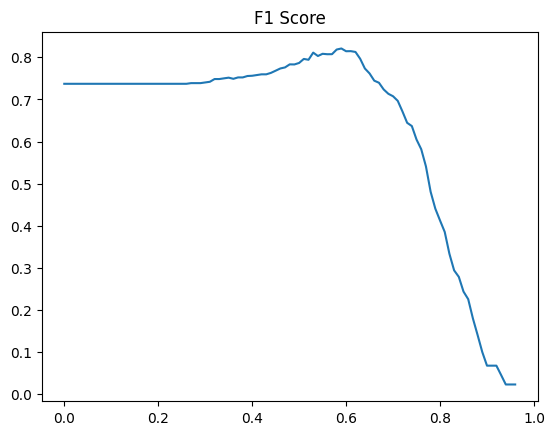

maximum point:  0.59


In [53]:
# Question 4: F1 Score

pred_results['f1'] = 2 * pred_results['precision'] * pred_results['recall'] / (pred_results['precision'] + pred_results['recall'])

plt.plot(pred_results['threshold'], pred_results['f1'])
plt.title('F1 Score')
plt.show()

print("maximum point: ",pred_results.iloc[pred_results['f1'].idxmax()]['threshold'])

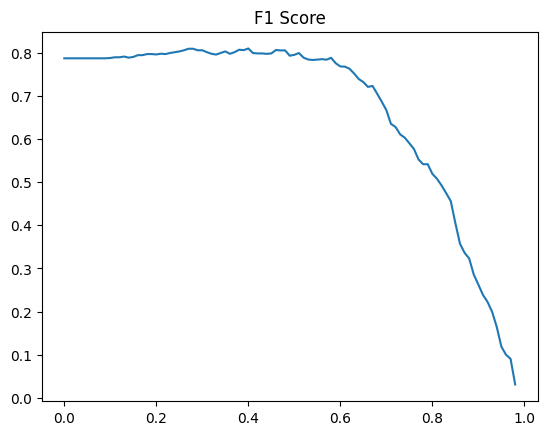

maximum point:  0.4


In [54]:
# Alternative: use all_train and test

pred2_results['f1'] = 2 * pred2_results['precision'] * pred2_results['recall'] / (pred2_results['precision'] + pred2_results['recall'])

plt.plot(pred2_results['threshold'], pred2_results['f1'])
plt.title('F1 Score')
plt.show()

print("maximum point: ",pred2_results.iloc[pred2_results['f1'].idxmax()]['threshold'])

In [ ]:
# Question 5: 5-Fold CV

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model
    
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)


print('C=1.0 mean=%.3f, std=%.3f' % (np.mean(scores), np.std(scores)))



# Use AUC to evaluate the model on validation


[0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
C=1.0 mean=0.822, std=0.036


In [ ]:
# Question 6: Hyperparameter Tuning